In [1]:
'''Ziel: Mittleren Immobilienpreis eines Bezirks aus anderen Angaben über den Bezirk vorhersagen.'''

'Ziel: Mittleren Immobilienpreis eines Bezirks aus anderen Angaben über den Bezirk vorhersagen.'

In [2]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from urllib.request import urlretrieve
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
import joblib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Activation
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError

In [3]:
URL = 'https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.csv'
DIR = '/home/olli/Projects/Immobilien'
FILENAME = 'housing.csv'

In [4]:
def save_data(url, filename):
    FILE = urlretrieve(url, filename=filename)

In [5]:
save_data(url=URL, filename=FILENAME)

In [6]:
def load_data(folder, filename):
    FILE = os.path.join(folder, filename)
    df = pd.read_csv(FILE)
    return df

In [7]:
df = load_data(folder=DIR, filename=FILENAME)

In [8]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [9]:
df.info()
#einige total_bedrooms fehlen
#alles numerische Features, ein Feature vom Typ object (Text)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [10]:
df['ocean_proximity'].value_counts()
#kategorisches Merkmal

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [11]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


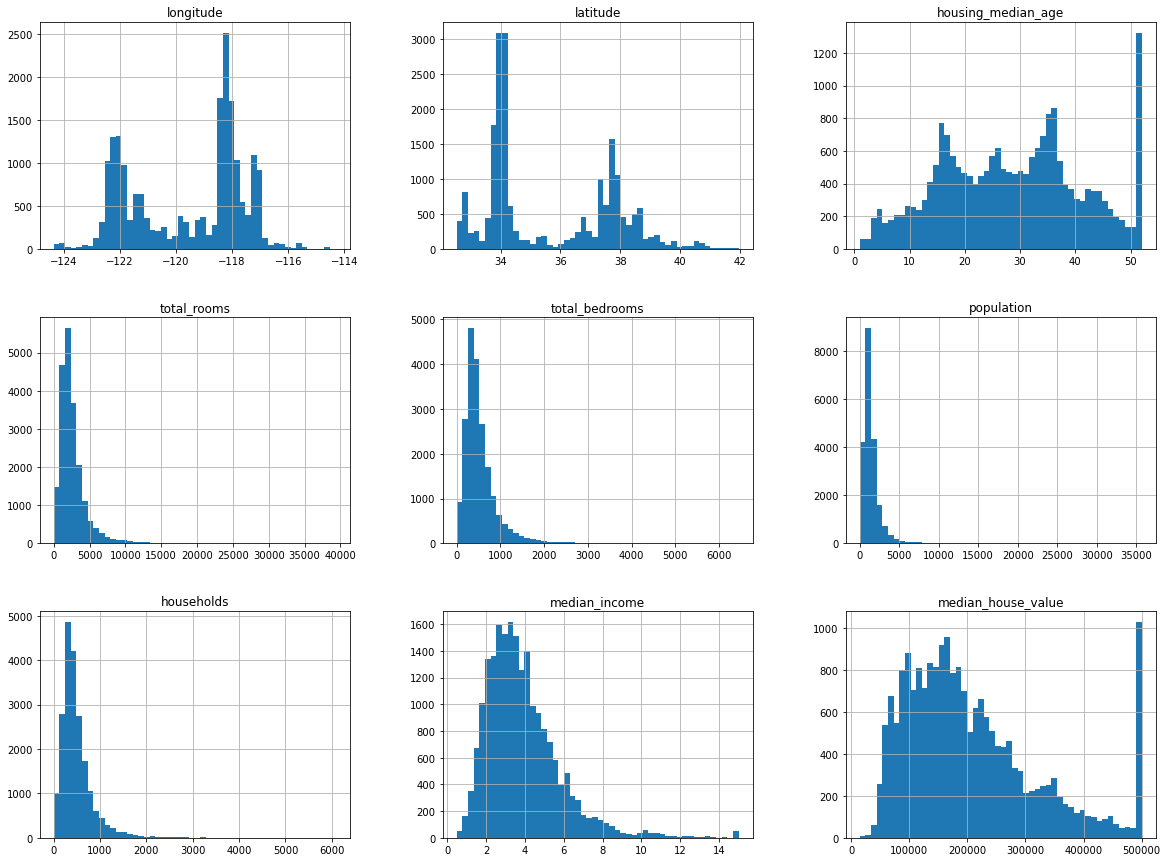

In [12]:
df.hist(bins=50, figsize=(20,15))
plt.show()
#median_income: Nach oben aggregiert (bei 15); Werte sind skaliert: 1 == 10.000 USD
#media_house_age: Über 50 ebenfalls abgekappt
#median_house_value: Über 500.000 abgekappt (Problem!) -> Vorhersage für über 500.000 $ nicht möglich
    # Werte nachträglich beschaffen oder die verfälschten Daten entfernen
#Einige Rechtsschief: Wertebereich deutlich weiter rechts vom Median (total_rooms, total_bedrooms, bedrooms, households, median_income)

In [13]:
#Testdatensatz erstellen
#Damit immer der selbe Testdatensatz verwendet wird: Abspeichern und später immer laden oder random-seed festlegen
#Beide Möglichkeiten scheitern bei aktualisierten Datensätzen
#Sollte Datensatz im Vgl. zu den Merkmalen nicht groß genug sein: Zufallsstichprobe gibt Stichproben-Bias -> Lösung: Stratifizierte (gewichtete) Stichprobe
def split_dataset(data):
    df = data.copy()
    y = df['median_house_value']
    X = df.drop('median_house_value', axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
    return X_train, X_test, y_train, y_test

In [14]:
X_train, X_test, y_train, y_test = split_dataset(df)

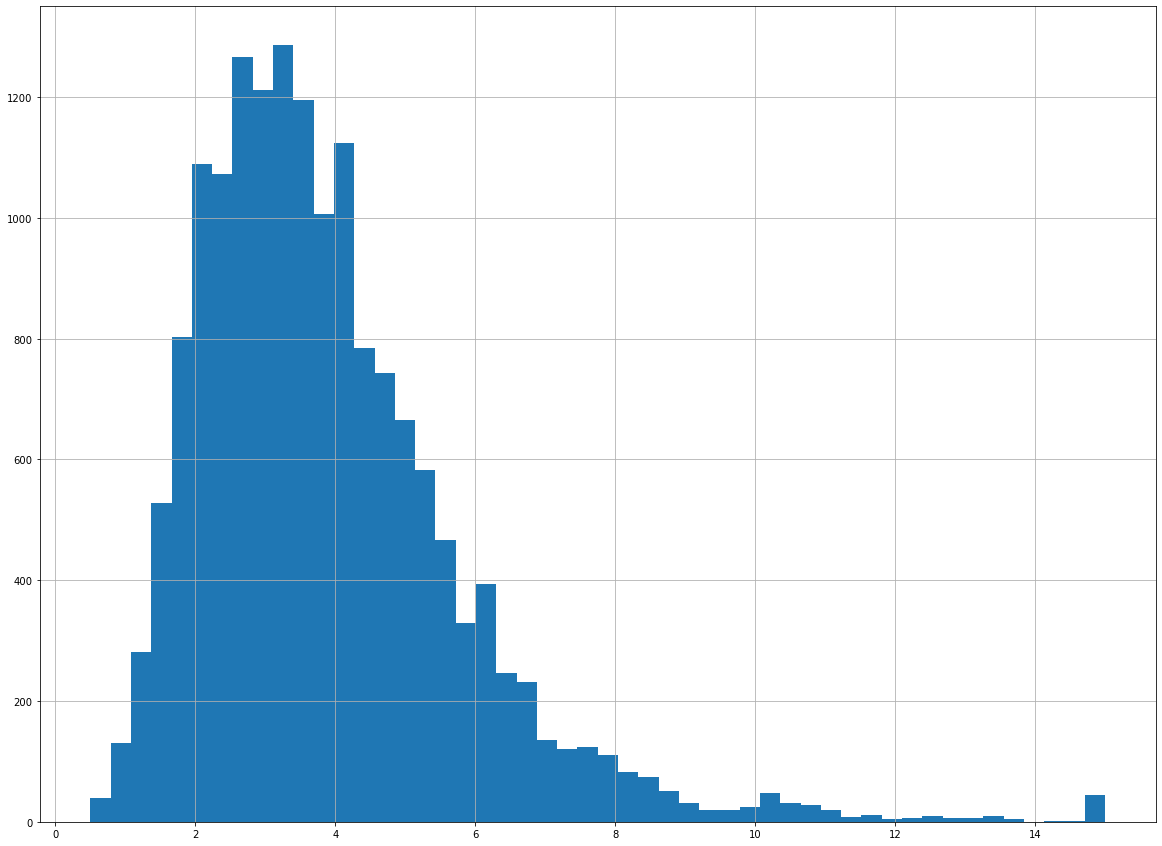

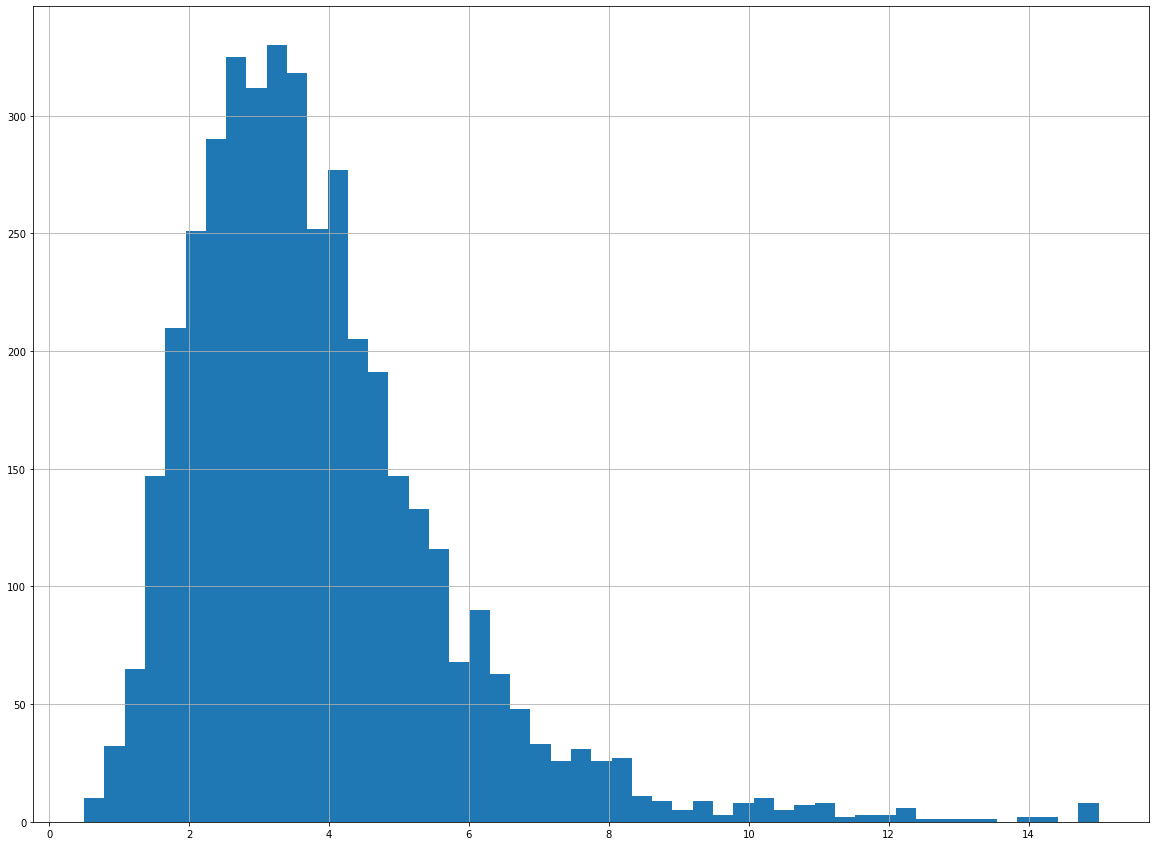

In [15]:
X_train['median_income'].hist(bins=50, figsize=(20,15))
plt.show()
X_test['median_income'].hist(bins=50, figsize=(20,15))
plt.show()
#wenn median_income als wichtiges Merkmal: Strstifizierte Stichprobe nötig

In [16]:
X_test.info()
#alle fehlenden total_bedrooms Werte im Testsample (???)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4128 entries, 20046 to 3665
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           4128 non-null   float64
 1   latitude            4128 non-null   float64
 2   housing_median_age  4128 non-null   float64
 3   total_rooms         4128 non-null   float64
 4   total_bedrooms      3921 non-null   float64
 5   population          4128 non-null   float64
 6   households          4128 non-null   float64
 7   median_income       4128 non-null   float64
 8   ocean_proximity     4128 non-null   object 
dtypes: float64(8), object(1)
memory usage: 322.5+ KB


In [17]:
#Genaueres erkunden der Daten
housing = X_train.copy()
housing_labels = y_train.copy()

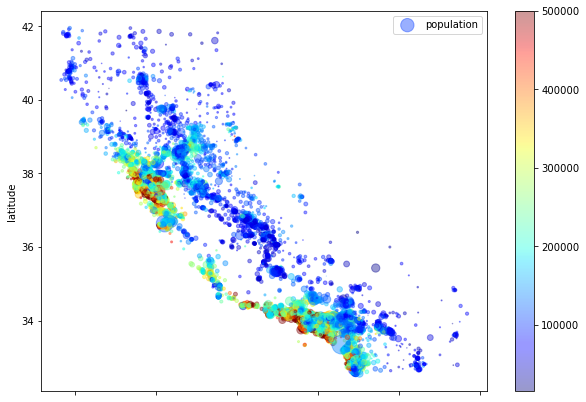

In [18]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, s=housing['population']/100,
             label='population', figsize=(10,7), cmap=plt.get_cmap('jet'), colorbar=True, c=housing_labels)
plt.legend()

In [19]:
#Nach Korrelationen suchen
housing.corrwith(housing_labels).sort_values(ascending=False)
#Alternativ mit Pandas-scatter_matrix() -> Nur mit einem Dataframe möglich

median_income         0.690647
total_rooms           0.133989
housing_median_age    0.103706
households            0.063714
total_bedrooms        0.047980
population           -0.026032
longitude            -0.046349
latitude             -0.142983
dtype: float64

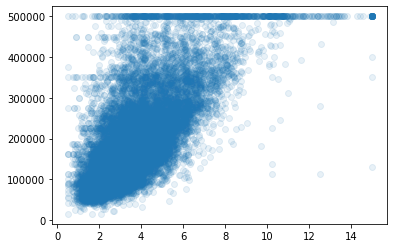

In [20]:
plt.scatter(housing['median_income'], housing_labels, alpha=0.1)
#waagerechte Linien könnten Probleme bereiten -> ggf. entfernen

In [21]:
pd.set_option("display.max_rows", None)

In [22]:
most = housing_labels.value_counts()
most

500001.0    786
137500.0     93
162500.0     89
112500.0     82
187500.0     73
225000.0     69
350000.0     66
87500.0      61
100000.0     53
275000.0     53
150000.0     48
175000.0     48
125000.0     46
250000.0     41
67500.0      39
200000.0     39
450000.0     30
118800.0     29
212500.0     28
93800.0      26
156300.0     25
143800.0     25
55000.0      25
193800.0     25
81300.0      24
106300.0     23
300000.0     23
400000.0     23
75000.0      23
500000.0     22
237500.0     22
131300.0     21
181300.0     21
325000.0     21
170800.0     21
262500.0     19
146900.0     19
90600.0      18
166700.0     18
258300.0     18
154200.0     18
182100.0     17
108300.0     17
165000.0     17
168800.0     16
146400.0     16
287500.0     16
129200.0     16
179200.0     16
218800.0     16
140600.0     16
206300.0     15
108900.0     15
145800.0     15
156800.0     15
375000.0     15
104200.0     15
116700.0     15
141700.0     15
266700.0     15
159400.0     15
158300.0     15
191100.0

In [23]:
pd.set_option("display.max_rows", 20)

In [24]:
to_remove = []
for number in range(len(most)):  # Alle Werte, welche öfter als 60 mal vorkommen, entfernen
    if most.iloc[number] > 60:
        to_remove.append(most.index[number])
    else:
        break
print(to_remove)

[500001.0, 137500.0, 162500.0, 112500.0, 187500.0, 225000.0, 350000.0, 87500.0]


In [25]:
#Dataframes zusammenfügen, um Zeilen entfernen zu können
housing['median_house_value'] = housing_labels

In [26]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
14196,-117.03,32.71,33.0,3126.0,627.0,2300.0,623.0,3.2596,NEAR OCEAN,103000.0
8267,-118.16,33.77,49.0,3382.0,787.0,1314.0,756.0,3.8125,NEAR OCEAN,382100.0
17445,-120.48,34.66,4.0,1897.0,331.0,915.0,336.0,4.1563,NEAR OCEAN,172600.0
14265,-117.11,32.69,36.0,1421.0,367.0,1418.0,355.0,1.9425,NEAR OCEAN,93400.0
2271,-119.80,36.78,43.0,2382.0,431.0,874.0,380.0,3.5542,INLAND,96500.0


In [27]:
filt = (housing['median_house_value'] == to_remove[0]) | (housing['median_house_value'] == to_remove[1]) | (housing['median_house_value'] == to_remove[2]) | (housing['median_house_value'] == to_remove[3]) | (housing['median_house_value'] == to_remove[4]) | (housing['median_house_value'] == to_remove[5]) | (housing['median_house_value'] == to_remove[6]) | (housing['median_house_value'] == to_remove[7]) 

In [28]:
housing.drop(housing.index[filt], inplace=True)

In [29]:
len(housing)

15193

In [30]:
houses = X_train.copy()

In [31]:
houses['median_house_value'] = y_train.copy()

In [32]:
houses.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
14196,-117.03,32.71,33.0,3126.0,627.0,2300.0,623.0,3.2596,NEAR OCEAN,103000.0
8267,-118.16,33.77,49.0,3382.0,787.0,1314.0,756.0,3.8125,NEAR OCEAN,382100.0
17445,-120.48,34.66,4.0,1897.0,331.0,915.0,336.0,4.1563,NEAR OCEAN,172600.0
14265,-117.11,32.69,36.0,1421.0,367.0,1418.0,355.0,1.9425,NEAR OCEAN,93400.0
2271,-119.80,36.78,43.0,2382.0,431.0,874.0,380.0,3.5542,INLAND,96500.0


In [33]:
len(houses)

16512

In [34]:
def remove_dublicates_abouve_60(data):
    most = data['median_house_value'].value_counts()  # gesuchte Werte in absteigender Reihenfolge
    to_remove = []
    for number in range(len(most)):  # Alle Werte, welche öfter als 60 mal vorkommen, entfernen
        if most.iloc[number] > 60:
            to_remove.append(most.index[number])
        else:  # Absteigend: Erster Wert unterschreitet 60 -> kein weiterer kommt mehr
            break
    # Filter erstellen, um damit die entsprechenden Zeilen zu entfernen
    for wert in to_remove:
        filt = (data['median_house_value'] == wert)
        data.drop(data.index[filt], inplace=True)
    
    return data

In [35]:
houses = remove_dublicates_abouve_60(houses)

In [36]:
len(houses)

15193

In [37]:
houses_labels = houses['median_house_value']

In [38]:
houses.drop('median_house_value', axis=1, inplace=True)

In [39]:
houses.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14196,-117.03,32.71,33.0,3126.0,627.0,2300.0,623.0,3.2596,NEAR OCEAN
8267,-118.16,33.77,49.0,3382.0,787.0,1314.0,756.0,3.8125,NEAR OCEAN
17445,-120.48,34.66,4.0,1897.0,331.0,915.0,336.0,4.1563,NEAR OCEAN
14265,-117.11,32.69,36.0,1421.0,367.0,1418.0,355.0,1.9425,NEAR OCEAN
2271,-119.80,36.78,43.0,2382.0,431.0,874.0,380.0,3.5542,INLAND


In [40]:
#Vorher fehlende Werte berücksichtigen -> total_bedrooms_NA mit median ersetzen
#Aber: Wert speichern für Testdatensatz [scikit-learn: SimpleImputer]
imputer = SimpleImputer(strategy='median')
#Imputer funktioniert nur bei numerischen Merkmalen -> houses in zwei teilen
#Fehlende Werte befinden sich seltsamerweise nur im Testdatensatz, Operation dennoch nötig

In [41]:
#Numerische Werte:
houses_num = houses.drop('ocean_proximity', axis=1)

In [42]:
houses_cat = houses['ocean_proximity']

In [43]:
imputer.fit(houses_num)

SimpleImputer(strategy='median')

In [44]:
X = imputer.transform(houses_num)

In [45]:
type(X)

numpy.ndarray

In [46]:
#Umwandlung zurück in Dataframe
houses_num = pd.DataFrame(X, columns=houses_num.columns, index=houses_num.index)

In [47]:
#Umwandeln der kategorischen Merkmale (ocean_proximity)
houses_cat.value_counts()

<1H OCEAN     6691
INLAND        5039
NEAR OCEAN    1841
NEAR BAY      1618
ISLAND           4
Name: ocean_proximity, dtype: int64

In [48]:
#OneHotEncoding oder OrdinalEncoder mit definierten Kategorien wählen:
cat_encoder = OneHotEncoder()

In [49]:
houses_cat_array = houses_cat.to_numpy()
houses_cat_array.shape

(15193,)

In [50]:
houses_cat_array = houses_cat_array.reshape(-1, 1)
houses_cat_array.shape

(15193, 1)

In [51]:
houses_cat_array

array([['NEAR OCEAN'],
       ['NEAR OCEAN'],
       ['NEAR OCEAN'],
       ...,
       ['<1H OCEAN'],
       ['<1H OCEAN'],
       ['NEAR BAY']], dtype=object)

In [52]:
houses_cat_encoded = cat_encoder.fit_transform(houses_cat_array)

In [53]:
houses_cat_encoded
#Kein Array, sondern Sparse-Matrix

<15193x5 sparse matrix of type '<class 'numpy.float64'>'
	with 15193 stored elements in Compressed Sparse Row format>

In [54]:
houses_cat_encoded = houses_cat_encoded.toarray()

In [55]:
houses_cat_encoded

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [56]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [57]:
#Feature Engineering -> Nach Test schneiden am besten die folgenden zwei Merkmale ab:
#1) households_per_population; 2) bedrooms_per_room
#Eigene Transformer bauen

In [58]:
X[0]

array([-117.03  ,   32.71  ,   33.    , 3126.    ,  627.    , 2300.    ,
        623.    ,    3.2596])

In [59]:
houses_num.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype='object')

In [60]:
col_names = ("total_rooms", "total_bedrooms", "population", "households")

In [61]:
#Richtigen Spalten dynamisch zuweisen
rooms_ix, bedrooms_ix, population_ix, households_ix = [houses.columns.get_loc(c) for c in col_names]

In [62]:
#Beide Merkmale als Hyperparameter austesten: Falls True -> Einzelnen Werte entfernen
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_households_per_population=True, add_bedrooms_per_room=True):
        self.add_households_per_population = add_households_per_population
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        households_per_population = X[:, population_ix] / X[:, rooms_ix]
        bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
        if self.add_households_per_population and self.add_bedrooms_per_room: # Beide übergeben
            return np.c_[X[:, 0], X[:, 1], X[:, 2], X[:, 7], households_per_population, bedrooms_per_room] # einzelnen 4 Spalten entfernen
        elif self.add_households_per_population == True and add_bedrooms_per_room == False: # Nur erstes hinzufügen
            return np.c_[X[:, 0], X[:, 1], X[:, 2], X[:, 3], X[:, 4], X[:, 7],
                                  households_per_population]
        elif self.add_households_per_population == False and add_bedrooms_per_room == True:
            return np.c_[X[:, 0], X[:, 1], X[:, 2], X[:, 5], X[:, 6], X[:, 7], bedrooms_per_room]
        else:
            return X # beides false -> nicht machen

In [63]:
attr_adder = CombinedAttributesAdder()

In [64]:
houses_num_extra_attribs = attr_adder.transform(houses_num.values)

In [65]:
houses_num_extra_attribs[0]

array([-117.03      ,   32.71      ,   33.        ,    3.2596    ,
          0.73576456,    0.20057582])

In [66]:
X[0]
#entfernt rooms, bedrooms, population, households und fügt bedrooms_per_room und households_per_population zu

array([-117.03  ,   32.71  ,   33.    , 3126.    ,  627.    , 2300.    ,
        623.    ,    3.2596])

In [67]:
#Skalieren der Merkmale: MinMaxScaler (Normalisieren) oder StandardScaler (Standardisieren)
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('min_mac_scaler', MinMaxScaler())
])

In [68]:
num_attribs = list(houses_num)
cat_attribs = ['ocean_proximity']

In [69]:
full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs)
])

In [70]:
houses_prepared = full_pipeline.fit_transform(houses)

In [101]:
houses_prepared[0]

array([0.72908367, 0.01702128, 0.62745098, 0.19032151, 0.00610335,
       0.15473202, 0.        , 0.        , 0.        , 0.        ,
       1.        ])

In [72]:
lin_reg = LinearRegression()

In [73]:
lin_reg.fit(houses_prepared, houses_labels)

LinearRegression()

In [74]:
houses_pred = lin_reg.predict(houses_prepared)

In [75]:
lin_mse = mean_squared_error(houses_labels, houses_pred)

In [76]:
lin_rmse = np.sqrt(lin_mse)

In [77]:
lin_rmse

61617.6591865458

In [78]:
#Zu testende Modelle: SVM; DecisionTree; RandomTree; NN
svr = SVR()

In [79]:
svr_params = [
    {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
     'degree': [1, 2, 3, 4],
     'C': [1, 10, 100, 1_000],
     'epsilon': [0, 0.1]}
]

In [82]:
svr_search = RandomizedSearchCV(svr, svr_params, cv=5, scoring='neg_mean_squared_error',
                                return_train_score=True, verbose=10)

In [83]:
svr_search.fit(houses_prepared, houses_labels)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START C=100, degree=4, epsilon=0.1, kernel=poly..................
[CV 1/5; 1/10] END C=100, degree=4, epsilon=0.1, kernel=poly;, score=(train=-5472276110.988, test=-5648257966.815) total time=   3.7s
[CV 2/5; 1/10] START C=100, degree=4, epsilon=0.1, kernel=poly..................
[CV 2/5; 1/10] END C=100, degree=4, epsilon=0.1, kernel=poly;, score=(train=-5503923844.151, test=-5457933012.135) total time=   3.6s
[CV 3/5; 1/10] START C=100, degree=4, epsilon=0.1, kernel=poly..................
[CV 3/5; 1/10] END C=100, degree=4, epsilon=0.1, kernel=poly;, score=(train=-5569143453.413, test=-5305006650.889) total time=   3.6s
[CV 4/5; 1/10] START C=100, degree=4, epsilon=0.1, kernel=poly..................
[CV 4/5; 1/10] END C=100, degree=4, epsilon=0.1, kernel=poly;, score=(train=-5446036910.339, test=-5579099526.670) total time=   3.7s
[CV 5/5; 1/10] START C=100, degree=4, epsilon=0.1, kernel=poly.................

[CV 4/5; 8/10] END C=100, degree=3, epsilon=0.1, kernel=linear;, score=(train=-6780476858.762, test=-6851200389.844) total time=   3.4s
[CV 5/5; 8/10] START C=100, degree=3, epsilon=0.1, kernel=linear................
[CV 5/5; 8/10] END C=100, degree=3, epsilon=0.1, kernel=linear;, score=(train=-6770414102.874, test=-6896984108.341) total time=   3.4s
[CV 1/5; 9/10] START C=100, degree=1, epsilon=0.1, kernel=poly..................
[CV 1/5; 9/10] END C=100, degree=1, epsilon=0.1, kernel=poly;, score=(train=-6956353027.967, test=-7090701074.220) total time=   3.5s
[CV 2/5; 9/10] START C=100, degree=1, epsilon=0.1, kernel=poly..................
[CV 2/5; 9/10] END C=100, degree=1, epsilon=0.1, kernel=poly;, score=(train=-6972994579.449, test=-6935860174.203) total time=   3.5s
[CV 3/5; 9/10] START C=100, degree=1, epsilon=0.1, kernel=poly..................
[CV 3/5; 9/10] END C=100, degree=1, epsilon=0.1, kernel=poly;, score=(train=-7037150746.590, test=-6753922164.332) total time=   3.6s
[C

RandomizedSearchCV(cv=5, estimator=SVR(),
                   param_distributions=[{'C': [1, 10, 100, 1000],
                                         'degree': [1, 2, 3, 4],
                                         'epsilon': [0, 0.1],
                                         'kernel': ['linear', 'poly', 'rbf',
                                                    'sigmoid']}],
                   return_train_score=True, scoring='neg_mean_squared_error',
                   verbose=10)

In [84]:
dir(svr_search)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_is_fitted',
 '_check_n_features',
 '_check_refit_for_multimetric',
 '_estimator_type',
 '_format_results',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_pairwise',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_required_parameters',
 '_run_search',
 '_validate_data',
 'best_estimator_',
 'best_index_',
 'best_params_',
 'best_score_',
 'classes_',
 'cv',
 'cv_results_',
 'decision_function',
 'error_score',
 'estimator',
 'fit',
 'get_params',
 'inverse_transform',
 'multimetric_',
 'n_features_in_',
 'n_iter',
 'n_jobs',

In [85]:
svr_search.best_params_

{'kernel': 'poly', 'epsilon': 0.1, 'degree': 4, 'C': 100}

In [86]:
svr_search.best_score_

-5503015026.779551

In [87]:
svr_rmse = np.sqrt(-svr_search.best_score_)

In [88]:
svr_rmse

74182.30939233121

In [79]:
#Weiteres Hyperparameter-Tuning möglich, aber Modell schneidet zu schlecht ab (rmse_best_svr=~74000)

In [81]:
#Polynomial Regression:
poly_results = {}
for degree in range(1,6):
    poly_features = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly = poly_features.fit_transform(houses_prepared)
    lin_reg_2 = LinearRegression()
    lin_reg_2_scores = cross_val_score(lin_reg_2, X_poly, houses_labels, scoring='neg_mean_squared_error', cv=3)
    lin_reg_2_rmse_scores = np.sqrt(-lin_reg_2_scores)
    poly_results[degree] = lin_reg_2_rmse_scores   


In [83]:
poly_results
#Deutlich schlechter

{1: array([ 61926.13394097, 164260.30840317,  62729.86188889]),
 2: array([1.37534355e+12, 6.91749978e+13, 1.76195203e+13]),
 3: array([6.09497306e+13, 5.10055191e+13, 1.12468489e+13]),
 4: array([1.86005632e+13, 4.69722876e+14, 8.41817989e+13]),
 5: array([7.60514909e+13, 1.88993316e+14, 5.05415219e+13])}

In [84]:
#DecisionTreeRegressor
dtr = DecisionTreeRegressor()

In [88]:
dtr_params = [
    {"splitter":["best","random"],
            "max_depth" : [1,3,5,7,9,11,12],
           "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
           "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.499],
           "max_features":["auto","log2","sqrt",None],
           "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90]}
]

In [89]:
dtr_search = RandomizedSearchCV(dtr, dtr_params, cv=5, scoring='neg_mean_squared_error',
                                return_train_score=True, verbose=10, n_iter=30)

In [90]:
dtr_search.fit(houses_prepared, houses_labels)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5; 1/30] START max_depth=9, max_features=None, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=random
[CV 1/5; 1/30] END max_depth=9, max_features=None, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=random;, score=(train=-7208930310.220, test=-7355415075.703) total time=   0.0s
[CV 2/5; 1/30] START max_depth=9, max_features=None, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=random
[CV 2/5; 1/30] END max_depth=9, max_features=None, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=random;, score=(train=-7254332152.603, test=-7175451887.754) total time=   0.0s
[CV 3/5; 1/30] START max_depth=9, max_features=None, max_leaf_nodes=None, min_samples_leaf=6, min_weight_fraction_leaf=0.3, splitter=random
[CV 3/5; 1/30] END max_depth=9, max_features=None, max_leaf_nodes=None, min_samples_leaf=6, min_

[CV 1/5; 11/30] END max_depth=3, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=(train=-7032719308.580, test=-7080063069.488) total time=   0.0s
[CV 2/5; 11/30] START max_depth=3, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best
[CV 2/5; 11/30] END max_depth=3, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=(train=-6026189691.083, test=-6085826649.841) total time=   0.0s
[CV 3/5; 11/30] START max_depth=3, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best
[CV 3/5; 11/30] END max_depth=3, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=7, min_weight_fraction_leaf=0.1, splitter=best;, score=(train=-6779289881.130, test=-6658518574.887) total time=   0.0s
[CV 4/5; 11/30] START max_depth=3, max_features=sqrt, max_leaf_nodes=90, min_samples_leaf=7, min_weigh

[CV 3/5; 23/30] END max_depth=9, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=(train=-4578339668.341, test=-4344431043.240) total time=   0.0s
[CV 4/5; 23/30] START max_depth=9, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best
[CV 4/5; 23/30] END max_depth=9, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=(train=-4532894516.335, test=-4655314907.834) total time=   0.0s
[CV 5/5; 23/30] START max_depth=9, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best
[CV 5/5; 23/30] END max_depth=9, max_features=auto, max_leaf_nodes=None, min_samples_leaf=4, min_weight_fraction_leaf=0.1, splitter=best;, score=(train=-4483925692.624, test=-4612642482.114) total time=   0.0s
[CV 1/5; 24/30] START max_depth=3, max_features=None, max_leaf_nodes=10, min_samples_leaf=10

[CV 3/5; 28/30] END max_depth=5, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best;, score=(train=-6510154144.631, test=-6279085035.872) total time=   0.0s
[CV 4/5; 28/30] START max_depth=5, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best
[CV 4/5; 28/30] END max_depth=5, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best;, score=(train=-6420711697.915, test=-6642619812.133) total time=   0.0s
[CV 5/5; 28/30] START max_depth=5, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best
[CV 5/5; 28/30] END max_depth=5, max_features=auto, max_leaf_nodes=10, min_samples_leaf=1, min_weight_fraction_leaf=0.3, splitter=best;, score=(train=-6399196074.315, test=-6581899119.783) total time=   0.0s
[CV 1/5; 29/30] START max_depth=12, max_features=sqrt, max_leaf_nodes=20, min_samples_leaf=8, min_weig

RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_iter=30,
                   param_distributions=[{'max_depth': [1, 3, 5, 7, 9, 11, 12],
                                         'max_features': ['auto', 'log2',
                                                          'sqrt', None],
                                         'max_leaf_nodes': [None, 10, 20, 30,
                                                            40, 50, 60, 70, 80,
                                                            90],
                                         'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                              7, 8, 9, 10],
                                         'min_weight_fraction_leaf': [0.1, 0.2,
                                                                      0.3, 0.4,
                                                                      0.499],
                                         'splitter': ['best', 'random']}],
           

In [116]:
dtr_search.best_params_

{'splitter': 'best',
 'min_weight_fraction_leaf': 0.1,
 'min_samples_leaf': 4,
 'max_leaf_nodes': None,
 'max_features': 'auto',
 'max_depth': 9}

In [93]:
dtr_best_rmse = np.sqrt(-dtr_search.best_score_)

In [96]:
dtr_best_rmse
#~67_500

67446.27092132071

In [98]:
#RandomForestRegressor
rfr = RandomForestRegressor()

In [99]:
rfr_params = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
}

In [100]:
rfr_search = RandomizedSearchCV(rfr, rfr_params, cv=5, scoring='neg_mean_squared_error',
                                return_train_score=True, verbose=10, n_iter=30)

In [102]:
rfr_search.fit(houses_prepared, houses_labels)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5; 1/30] START bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1800
[CV 1/5; 1/30] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1800;, score=(train=-466016595.993, test=-1770047358.767) total time=  18.0s
[CV 2/5; 1/30] START bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1800
[CV 2/5; 1/30] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1800;, score=(train=-459051881.111, test=-1871553336.464) total time=  18.0s
[CV 3/5; 1/30] START bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1800
[CV 3/5; 1/30] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1800;, score=(train=-465145251.

[CV 1/5; 6/30] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400;, score=(train=-577454499.903, test=-1794116615.001) total time=   4.0s
[CV 2/5; 6/30] START bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400
[CV 2/5; 6/30] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400;, score=(train=-573092126.904, test=-1893036194.438) total time=   4.0s
[CV 3/5; 6/30] START bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400
[CV 3/5; 6/30] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400;, score=(train=-574158241.253, test=-1786635480.986) total time=   4.0s
[CV 4/5; 6/30] START bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400
[CV 4/5; 6/30] END boo

[CV 1/5; 11/30] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=(train=-590883017.767, test=-1806541433.119) total time=   2.8s
[CV 2/5; 11/30] START bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200
[CV 2/5; 11/30] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=(train=-571029488.285, test=-1879727274.494) total time=   2.8s
[CV 3/5; 11/30] START bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200
[CV 3/5; 11/30] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=(train=-586545961.712, test=-1799748529.210) total time=   2.7s
[CV 4/5; 11/30] START bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200
[CV 4/5; 1

[CV 1/5; 16/30] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=(train=-391335373.499, test=-1939680144.255) total time=   6.2s
[CV 2/5; 16/30] START bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200
[CV 2/5; 16/30] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=(train=-382210073.796, test=-2001991794.612) total time=   6.2s
[CV 3/5; 16/30] START bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200
[CV 3/5; 16/30] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=(train=-382990547.564, test=-1870604827.078) total time=   6.2s
[CV 4/5; 16/30] START bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200
[CV 4/5; 16/30] 

[CV 1/5; 21/30] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600;, score=(train=-1072439425.756, test=-1887578638.037) total time=   5.2s
[CV 2/5; 21/30] START bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600
[CV 2/5; 21/30] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600;, score=(train=-1052909859.340, test=-1972516392.762) total time=   5.2s
[CV 3/5; 21/30] START bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600
[CV 3/5; 21/30] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600;, score=(train=-1066351553.186, test=-1872659467.548) total time=   5.2s
[CV 4/5; 21/30] START bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600
[CV 4/5

[CV 1/5; 26/30] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1800;, score=(train=-6.858, test=-1712713567.266) total time=  33.0s
[CV 2/5; 26/30] START bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1800
[CV 2/5; 26/30] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1800;, score=(train=-5.882, test=-1826176085.909) total time=  33.0s
[CV 3/5; 26/30] START bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1800
[CV 3/5; 26/30] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1800;, score=(train=-5.468, test=-1700201002.259) total time=  33.2s
[CV 4/5; 26/30] START bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1800
[CV 4/5; 26/30] END bootstra

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=30,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   return_train_score=True, scoring='neg_mean_squared_error',
                   verbose=10)

In [103]:
rfr_search.best_params_

{'n_estimators': 1800,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 90,
 'bootstrap': False}

In [104]:
rfr_best_rmse = np.sqrt(-rfr_search.best_score_)

In [106]:
rfr_best_rmse
#41832.09589374455

41832.09589374455

In [182]:
rfr_params_2 = {
    'n_estimators': list(range(1600, 2000, 10)),
    'min_samples_split': [1, 2, 3],
    'min_samples_leaf': [1],
    'max_features': ['sqrt'],
    'max_depth': [85, 90, 95],
    'bootstrap': [False]
}

In [183]:
rfr_search_2 = RandomizedSearchCV(RandomForestRegressor(), rfr_params_2, cv=5, scoring='neg_mean_squared_error',
                                  return_train_score=True, verbose=10, n_iter=20)

In [184]:
rfr_search_2.fit(houses_prepared, houses_labels)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5; 1/20] START bootstrap=False, max_depth=85, max_features=sqrt, min_samples_leaf=1, min_samples_split=1, n_estimators=1630
[CV 1/5; 1/20] END bootstrap=False, max_depth=85, max_features=sqrt, min_samples_leaf=1, min_samples_split=1, n_estimators=1630;, score=(train=nan, test=nan) total time=   0.2s
[CV 2/5; 1/20] START bootstrap=False, max_depth=85, max_features=sqrt, min_samples_leaf=1, min_samples_split=1, n_estimators=1630
[CV 2/5; 1/20] END bootstrap=False, max_depth=85, max_features=sqrt, min_samples_leaf=1, min_samples_split=1, n_estimators=1630;, score=(train=nan, test=nan) total time=   0.2s
[CV 3/5; 1/20] START bootstrap=False, max_depth=85, max_features=sqrt, min_samples_leaf=1, min_samples_split=1, n_estimators=1630
[CV 3/5; 1/20] END bootstrap=False, max_depth=85, max_features=sqrt, min_samples_leaf=1, min_samples_split=1, n_estimators=1630;, score=(train=nan, test=nan) total time=   0.2s
[CV 4/5; 1/20] ST

[CV 2/5; 6/20] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=1950;, score=(train=-9677766.328, test=-1825749531.135) total time=  33.3s
[CV 3/5; 6/20] START bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=1950
[CV 3/5; 6/20] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=1950;, score=(train=-9774505.836, test=-1693860525.847) total time=  33.6s
[CV 4/5; 6/20] START bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=1950
[CV 4/5; 6/20] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=1950;, score=(train=-9994376.684, test=-1716779913.101) total time=  33.7s
[CV 5/5; 6/20] START bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=1950
[CV 5/5; 6/20] E

[CV 4/5; 11/20] END bootstrap=False, max_depth=85, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=1760;, score=(train=-10013008.069, test=-1721317973.733) total time=  30.5s
[CV 5/5; 11/20] START bootstrap=False, max_depth=85, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=1760
[CV 5/5; 11/20] END bootstrap=False, max_depth=85, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=1760;, score=(train=-10063896.829, test=-1796143297.873) total time=  30.3s
[CV 1/5; 12/20] START bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=1780
[CV 1/5; 12/20] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=1780;, score=(train=-9930146.540, test=-1709011437.156) total time=  30.9s
[CV 2/5; 12/20] START bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=1780
[CV 2/5;

[CV 5/5; 16/20] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=1, n_estimators=1720;, score=(train=nan, test=nan) total time=   0.2s
[CV 1/5; 17/20] START bootstrap=False, max_depth=95, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1880
[CV 1/5; 17/20] END bootstrap=False, max_depth=95, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1880;, score=(train=-3.125, test=-1711490144.315) total time=  34.4s
[CV 2/5; 17/20] START bootstrap=False, max_depth=95, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1880
[CV 2/5; 17/20] END bootstrap=False, max_depth=95, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1880;, score=(train=-5.132, test=-1824424063.767) total time=  34.5s
[CV 3/5; 17/20] START bootstrap=False, max_depth=95, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1880
[CV 3/5; 17/20] END bootstrap=False, max_de

/home/olli/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
40 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/home/olli/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/olli/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 450, in fit
    trees = Parallel(
  File "/home/olli/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterato

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=20,
                   param_distributions={'bootstrap': [False],
                                        'max_depth': [85, 90, 95],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': [1],
                                        'min_samples_split': [1, 2, 3],
                                        'n_estimators': [1600, 1610, 1620, 1630,
                                                         1640, 1650, 1660, 1670,
                                                         1680, 1690, 1700, 1710,
                                                         1720, 1730, 1740, 1750,
                                                         1760, 1770, 1780, 1790,
                                                         1800, 1810, 1820, 1830,
                                                         1840, 1850, 1860, 1870,
                              

In [185]:
rfr_search_2.best_params_

{'n_estimators': 1850,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 85,
 'bootstrap': False}

In [186]:
rfr_2_rmse = np.sqrt(-rfr_search_2.best_score_)

In [188]:
rfr_2_rmse
#~41_700

41783.4001671085

In [116]:
best_rfr = RandomForestRegressor(
    n_estimators=1850,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    max_depth=85,
    bootstrap=False
)

In [118]:
best_rfr.fit(houses_prepared, houses_labels)

RandomForestRegressor(bootstrap=False, max_depth=85, max_features='sqrt',
                      n_estimators=1850)

In [119]:
best_rfr_scores = cross_val_score(best_rfr, houses_prepared, houses_labels,
                                  scoring='neg_mean_squared_error', cv=10)

In [120]:
best_rfr_rmse = np.sqrt(-best_rfr_scores)

In [121]:
best_rfr_rmse.mean()

41322.718171113476

In [122]:
joblib.dump(best_rfr, 'MODEL_RFR_41322_RMSE.joblib')

['MODEL_RFR_41322_RMSE.joblib']

In [138]:
gbrt = GradientBoostingRegressor(
    n_estimators = 1800,
    min_samples_split = 2,
    min_samples_leaf = 1,
    max_features = 'sqrt',
    max_depth = 90
)

In [139]:
gbrt_score = cross_val_score(gbrt, houses_prepared, houses_labels, scoring='neg_mean_squared_error', cv=10)

In [140]:
gbrt_rmse = np.sqrt(-gbrt_score)

In [142]:
gbrt_rmse.mean()

42848.57813541341

In [143]:
gbrt_2 = GradientBoostingRegressor()

In [147]:
gbrt_2_params = {
    'n_estimators': [200, 600, 1000, 1400, 1800, 2500],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [10, 50, 90, 150]
}

In [149]:
gbrt_search = RandomizedSearchCV(gbrt_2, gbrt_2_params, cv=3, verbose=10, n_iter=30,
                                 scoring='neg_mean_squared_error', return_train_score=True)

In [150]:
gbrt_search.fit(houses_prepared, houses_labels)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV 1/3; 1/30] START max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1000
[CV 1/3; 1/30] END max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1000;, score=(train=-58907.911, test=-2115191975.588) total time= 2.5min
[CV 2/3; 1/30] START max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1000
[CV 2/3; 1/30] END max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1000;, score=(train=-33970.574, test=-2001050895.245) total time= 2.5min
[CV 3/3; 1/30] START max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1000
[CV 3/3; 1/30] END max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1000;, score=(train=-1430.021, test=-2141728066.108) total time= 2.5min
[CV 1/3; 2/30] START max_depth=50, max_features=auto, min_

[CV 2/3; 10/30] END max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1400;, score=(train=-0.000, test=-1842219347.784) total time=   4.7s
[CV 3/3; 10/30] START max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1400
[CV 3/3; 10/30] END max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1400;, score=(train=-0.000, test=-1986849199.830) total time=   4.7s
[CV 1/3; 11/30] START max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200
[CV 1/3; 11/30] END max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=(train=-423.521, test=-1847086402.886) total time=   5.6s
[CV 2/3; 11/30] START max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200
[CV 2/3; 11/30] END max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=(train=-

[CV 1/3; 20/30] END max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1800;, score=(train=-0.000, test=-1786502281.721) total time=  46.6s
[CV 2/3; 20/30] START max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1800
[CV 2/3; 20/30] END max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1800;, score=(train=-0.000, test=-1784427637.125) total time=  53.2s
[CV 3/3; 20/30] START max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1800
[CV 3/3; 20/30] END max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1800;, score=(train=-0.000, test=-1887451861.933) total time=  51.9s
[CV 1/3; 21/30] START max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1800
[CV 1/3; 21/30] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1800;, score=(trai

[CV 3/3; 29/30] END max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1800;, score=(train=-0.000, test=-2261091630.037) total time= 1.2min
[CV 1/3; 30/30] START max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1400
[CV 1/3; 30/30] END max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1400;, score=(train=-0.000, test=-1826922168.878) total time=  37.7s
[CV 2/3; 30/30] START max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1400
[CV 2/3; 30/30] END max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1400;, score=(train=-0.000, test=-1727213512.687) total time=  40.0s
[CV 3/3; 30/30] START max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1400
[CV 3/3; 30/30] END max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1400;, score=(train=-0

RandomizedSearchCV(cv=3, estimator=GradientBoostingRegressor(), n_iter=30,
                   param_distributions={'max_depth': [10, 50, 90, 150],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 600, 1000, 1400,
                                                         1800, 2500]},
                   return_train_score=True, scoring='neg_mean_squared_error',
                   verbose=10)

In [154]:
gbrt_search.best_params_
#Parameter am äußeren Rand -> Weiter Tunen

{'n_estimators': 2500,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 10}

In [152]:
gbrt_rmse = np.sqrt(-gbrt_search.best_score_)

In [153]:
gbrt_rmse

41293.67841809551

In [156]:
gbrt_2_params_2 = {
    'n_estimators': [2000, 2500, 3000],
    'min_samples_split': [4, 5, 6],
    'min_samples_leaf': [3, 4, 5],
    'max_features': ['sqrt'],
    'max_depth': [5, 10, 20]
}

In [157]:
gbrt_search_2 = RandomizedSearchCV(gbrt_2, gbrt_2_params_2, cv=3, verbose=10, n_iter=15,
                                 scoring='neg_mean_squared_error', return_train_score=True)

In [159]:
gbrt_search_2.fit(houses_prepared, houses_labels)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV 1/3; 1/15] START max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=3000
[CV 1/3; 1/15] END max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=3000;, score=(train=-0.000, test=-1788063321.092) total time=  41.0s
[CV 2/3; 1/15] START max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=3000
[CV 2/3; 1/15] END max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=3000;, score=(train=-0.000, test=-1733651933.992) total time=  37.6s
[CV 3/3; 1/15] START max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=3000
[CV 3/3; 1/15] END max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=3000;, score=(train=-0.000, test=-1885242964.655) total time=  37.3s
[CV 1/3; 2/15] START max_depth=20, max_features=sqrt, min_samples_leaf=4, m

[CV 2/3; 10/15] END max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=3000;, score=(train=-0.000, test=-1768953012.349) total time=  28.7s
[CV 3/3; 10/15] START max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=3000
[CV 3/3; 10/15] END max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=3000;, score=(train=-0.000, test=-1881526615.163) total time=  23.7s
[CV 1/3; 11/15] START max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=4, n_estimators=2000
[CV 1/3; 11/15] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=4, n_estimators=2000;, score=(train=-4482.604, test=-1708795564.594) total time=  18.8s
[CV 2/3; 11/15] START max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=4, n_estimators=2000
[CV 2/3; 11/15] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=4, n_estimators=2000;, score=(train=

RandomizedSearchCV(cv=3, estimator=GradientBoostingRegressor(), n_iter=15,
                   param_distributions={'max_depth': [5, 10, 20],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': [3, 4, 5],
                                        'min_samples_split': [4, 5, 6],
                                        'n_estimators': [2000, 2500, 3000]},
                   return_train_score=True, scoring='neg_mean_squared_error',
                   verbose=10)

In [161]:
gbrt_search_2.best_params_
#max_depth weiter tunen

{'n_estimators': 2000,
 'min_samples_split': 4,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 5}

In [165]:
gbrt_2_params_3 = {
    'n_estimators': [2000],
    'min_samples_split': [3, 4],
    'min_samples_leaf': [4],
    'max_features': ['sqrt'],
    'max_depth': list(range(1,7))
}

In [166]:
#Alle Kombis austesten -> GridSearchCV
gbrt_search_3 = GridSearchCV(GradientBoostingRegressor(), gbrt_2_params_3, cv=3, verbose=10,
                             scoring='neg_mean_squared_error', return_train_score=True)

In [167]:
gbrt_search_3.fit(houses_prepared, houses_labels)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3; 1/12] START max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=3, n_estimators=2000
[CV 1/3; 1/12] END max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=3, n_estimators=2000;, score=(train=-2432007582.423, test=-2602366617.338) total time=   2.4s
[CV 2/3; 1/12] START max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=3, n_estimators=2000
[CV 2/3; 1/12] END max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=3, n_estimators=2000;, score=(train=-2484274689.202, test=-2470080639.118) total time=   2.5s
[CV 3/3; 1/12] START max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=3, n_estimators=2000
[CV 3/3; 1/12] END max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=3, n_estimators=2000;, score=(train=-2373711772.095, test=-2741932773.149) total time=   2.5s
[CV 1/3; 2/12] START max_depth=1, max_features=sqrt, m

[CV 2/3; 10/12] END max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=2000;, score=(train=-152827959.170, test=-1603584923.138) total time=  10.2s
[CV 3/3; 10/12] START max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=2000
[CV 3/3; 10/12] END max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=2000;, score=(train=-144939920.241, test=-1710527511.475) total time=  10.1s
[CV 1/3; 11/12] START max_depth=6, max_features=sqrt, min_samples_leaf=4, min_samples_split=3, n_estimators=2000
[CV 1/3; 11/12] END max_depth=6, max_features=sqrt, min_samples_leaf=4, min_samples_split=3, n_estimators=2000;, score=(train=-37167217.593, test=-1648223107.879) total time=  12.0s
[CV 2/3; 11/12] START max_depth=6, max_features=sqrt, min_samples_leaf=4, min_samples_split=3, n_estimators=2000
[CV 2/3; 11/12] END max_depth=6, max_features=sqrt, min_samples_leaf=4, min_samples_split=3, n_estimators=2000;, 

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6],
                         'max_features': ['sqrt'], 'min_samples_leaf': [4],
                         'min_samples_split': [3, 4], 'n_estimators': [2000]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=10)

In [169]:
gbrt_search_3.best_params_

{'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 3,
 'n_estimators': 2000}

In [170]:
gbrt_3_rmse = np.sqrt(-gbrt_search_3.best_score_)

In [172]:
gbrt_3_rmse
#~40_500 -> Modell saven

40641.03762282004

In [108]:
best_gbrt = GradientBoostingRegressor(
    max_depth=5,
    max_features='sqrt',
    min_samples_leaf=4,
    min_samples_split=3,
    n_estimators=2000)

In [109]:
best_gbrt.fit(houses_prepared, houses_labels)

GradientBoostingRegressor(max_depth=5, max_features='sqrt', min_samples_leaf=4,
                          min_samples_split=3, n_estimators=2000)

In [111]:
score_best_gbrt = cross_val_score(best_gbrt, houses_prepared, houses_labels, scoring='neg_mean_squared_error', cv=10)

In [112]:
best_gbrt_rmse = np.sqrt(-score_best_gbrt)

In [114]:
best_gbrt_rmse.mean()

39844.75814060871

In [115]:
joblib.dump(best_gbrt, 'MODEL_GBRT_39844_RMSE.joblib')

['MODEL_GBRT_39844_RMSE.joblib']

In [71]:
type(houses_prepared[0][0])

numpy.float64

In [72]:
X = houses_prepared.copy()

In [73]:
X = X.astype('float32')

In [74]:
type(X[0][0])

numpy.float32

In [75]:
type(houses_labels)

pandas.core.series.Series

In [76]:
y = houses_labels.copy()

In [77]:
y = np.array(y, dtype='float32')

In [78]:
y.shape

(15193,)

In [79]:
y.dtype

dtype('float32')

In [80]:
type(y)

numpy.ndarray

In [82]:
#NN
def build_model(hp):
    model = keras.models.Sequential()
    model.add(Flatten())#input_shape=(houses_prepared.shape[1])))
        
    model.add(Dense(units=hp.Int('1_Dense_Units', 32, 256, 32)))
    if hp.Boolean('1_BatchNorm'):
        model.add(BatchNormalization())
    model.add(Activation('relu'))
    if hp.Boolean('1_Dropout'):
        model.add(Dropout(rate=hp.Float('1_Drop_Rate', 0.1, 0.5, 0.1)))
    
    model.add(Dense(units=hp.Int('2_Dense_Units', 32, 256, 32)))
    if hp.Boolean('2_BatchNorm'):
        model.add(BatchNormalization())
    model.add(Activation('relu'))
    if hp.Boolean('2_Dropout'):
        model.add(Dropout(rate=hp.Float('2_Drop_Rate', 0.1, 0.5, 0.1)))
    
    if hp.Boolean('3_Dense'):
        model.add(Dense(units=hp.Int('3_Dense_Units', 32, 256, 32)))
        if hp.Boolean('3_BatchNorm'):
            model.add(BatchNormalization())
        model.add(Activation('relu'))
        if hp.Boolean('3_Dropout'):
            model.add(Dropout(rate=hp.Float('3_Drop_Rate', 0.1, 0.5, 0.1)))
        
    if hp.Boolean('4_Dense'):
        model.add(Dense(units=hp.Int('4_Dense_Units', 32, 256, 32)))
        if hp.Boolean('4_BatchNorm'):
            model.add(BatchNormalization())
        model.add(Activation('relu'))
        if hp.Boolean('4_Dropout'):
            model.add(Dropout(rate=hp.Float('4_Drop_Rate', 0.1, 0.5, 0.1)))
    
    model.add(Dense(1, activation='relu'))
    
    LEARNING_RATE = hp.Float('Learning_Rate', 1e-5, 1e-2, sampling='log')
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                  loss=MeanSquaredError(),
                  metrics=[RootMeanSquaredError()])
        
    return model
    

In [83]:
tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective='val_loss',
    max_trials=1500,
    directory='Immobilien_Logs_1')

2022-02-14 11:45:34.381017: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-14 11:45:34.385027: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-14 11:45:34.385542: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-14 11:45:34.386589: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [84]:
tuner.search(X, y, epochs=1, batch_size=32, validation_split=0.2)

Trial 1500 Complete [00h 00m 00s]
val_loss: 47131070464.0

Best val_loss So Far: 3695799040.0
Total elapsed time: 00h 31m 35s
INFO:tensorflow:Oracle triggered exit


In [85]:
dir(tuner)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_build_and_fit_model',
 '_build_hypermodel',
 '_checkpoint_model',
 '_configure_tensorboard_dir',
 '_deepcopy_callbacks',
 '_delete_checkpoint',
 '_display',
 '_get_checkpoint_dir',
 '_get_checkpoint_fname',
 '_get_tensorboard_dir',
 '_get_tuner_fname',
 '_override_compile_args',
 '_populate_initial_space',
 '_reported_step',
 '_save_n_checkpoints',
 '_try_build',
 'directory',
 'distribution_strategy',
 'executions_per_trial',
 'get_best_hyperparameters',
 'get_best_models',
 'get_state',
 'get_trial_dir',
 'hypermodel',
 'load_model',
 'logger',
 'loss',
 'max_model_size',
 'metrics',
 'on_batch_begin',
 'on_batch_end'

In [86]:
tuner.search_space_summary()

Search space summary
Default search space size: 19
1_Dense_Units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
1_BatchNorm (Boolean)
{'default': False, 'conditions': []}
1_Dropout (Boolean)
{'default': False, 'conditions': []}
2_Dense_Units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
2_BatchNorm (Boolean)
{'default': False, 'conditions': []}
2_Dropout (Boolean)
{'default': False, 'conditions': []}
3_Dense (Boolean)
{'default': False, 'conditions': []}
4_Dense (Boolean)
{'default': False, 'conditions': []}
Learning_Rate (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
2_Drop_Rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
4_Dense_Units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling

In [87]:
tuner.results_summary()

Results summary
Results in Immobilien_Logs_1/untitled_project
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
1_Dense_Units: 224
1_BatchNorm: True
1_Dropout: False
2_Dense_Units: 96
2_BatchNorm: True
2_Dropout: False
3_Dense: True
4_Dense: True
Learning_Rate: 0.009708556515007514
2_Drop_Rate: 0.30000000000000004
4_Dense_Units: 128
4_BatchNorm: False
4_Dropout: True
1_Drop_Rate: 0.2
3_Dense_Units: 224
3_BatchNorm: True
3_Dropout: True
3_Drop_Rate: 0.5
4_Drop_Rate: 0.2
Score: 3695799040.0
Trial summary
Hyperparameters:
1_Dense_Units: 96
1_BatchNorm: True
1_Dropout: True
2_Dense_Units: 224
2_BatchNorm: False
2_Dropout: False
3_Dense: True
4_Dense: True
Learning_Rate: 0.009487463462564344
2_Drop_Rate: 0.1
4_Dense_Units: 96
4_BatchNorm: False
4_Dropout: True
1_Drop_Rate: 0.4
3_Dense_Units: 160
3_BatchNorm: True
3_Dropout: True
3_Drop_Rate: 0.5
4_Drop_Rate: 0.30000000000000004
Score: 3787133184.0
Trial summary
Hyperparameters:
1_Dense_Units: 

In [88]:
nn_best_params = tuner.get_best_hyperparameters()[0]

In [89]:
nn = tuner.hypermodel.build(nn_best_params)

In [92]:
tb = keras.callbacks.TensorBoard()
es = keras.callbacks.EarlyStopping(patience=20)
mc = keras.callbacks.ModelCheckpoint(filepath='nn_best.h5', save_best_only=True)
cb = [tb, es, mc]

In [93]:
nn.fit(X, y, epochs=100, batch_size=32, validation_split=0.2, callbacks=cb)

Epoch 1/100
380/380 [==============================] - 1s 2ms/step - loss: 3318210048.0000 - root_mean_squared_error: 57603.9062 - val_loss: 3048652544.0000 - val_root_mean_squared_error: 55214.6055
Epoch 2/100
380/380 [==============================] - 1s 2ms/step - loss: 3265513728.0000 - root_mean_squared_error: 57144.6719 - val_loss: 3120680192.0000 - val_root_mean_squared_error: 55863.0469
Epoch 3/100
380/380 [==============================] - 1s 2ms/step - loss: 3183108096.0000 - root_mean_squared_error: 56419.0391 - val_loss: 4234576128.0000 - val_root_mean_squared_error: 65073.6211
Epoch 4/100
380/380 [==============================] - 1s 2ms/step - loss: 3266402048.0000 - root_mean_squared_error: 57152.4453 - val_loss: 3292301312.0000 - val_root_mean_squared_error: 57378.5781
Epoch 5/100
380/380 [==============================] - 1s 2ms/step - loss: 3170653184.0000 - root_mean_squared_error: 56308.5508 - val_loss: 2969016320.0000 - val_root_mean_squared_error: 54488.6797
Epoch

380/380 [==============================] - 1s 3ms/step - loss: 2948017408.0000 - root_mean_squared_error: 54295.6484 - val_loss: 3464148224.0000 - val_root_mean_squared_error: 58857.0156
Epoch 43/100
380/380 [==============================] - 1s 2ms/step - loss: 2879726080.0000 - root_mean_squared_error: 53663.0781 - val_loss: 2821268992.0000 - val_root_mean_squared_error: 53115.6172
Epoch 44/100
380/380 [==============================] - 1s 2ms/step - loss: 2835713536.0000 - root_mean_squared_error: 53251.4180 - val_loss: 3073120000.0000 - val_root_mean_squared_error: 55435.7266
Epoch 45/100
380/380 [==============================] - 1s 3ms/step - loss: 2848201472.0000 - root_mean_squared_error: 53368.5430 - val_loss: 2797491456.0000 - val_root_mean_squared_error: 52891.3164
Epoch 46/100
380/380 [==============================] - 1s 3ms/step - loss: 2914400000.0000 - root_mean_squared_error: 53985.1836 - val_loss: 2523430400.0000 - val_root_mean_squared_error: 50233.7578
Epoch 47/100


380/380 [==============================] - 1s 3ms/step - loss: 2733024512.0000 - root_mean_squared_error: 52278.3359 - val_loss: 2649205248.0000 - val_root_mean_squared_error: 51470.4336
Epoch 84/100
380/380 [==============================] - 1s 3ms/step - loss: 2779181312.0000 - root_mean_squared_error: 52717.9414 - val_loss: 3249027072.0000 - val_root_mean_squared_error: 57000.2383
Epoch 85/100
380/380 [==============================] - 1s 3ms/step - loss: 2722416896.0000 - root_mean_squared_error: 52176.7852 - val_loss: 2851674368.0000 - val_root_mean_squared_error: 53401.0703
Epoch 86/100
380/380 [==============================] - 1s 3ms/step - loss: 2726524160.0000 - root_mean_squared_error: 52216.1289 - val_loss: 2579904000.0000 - val_root_mean_squared_error: 50792.7539
Epoch 87/100
380/380 [==============================] - 1s 2ms/step - loss: 2881305088.0000 - root_mean_squared_error: 53677.7891 - val_loss: 2968551168.0000 - val_root_mean_squared_error: 54484.4102
Epoch 88/100


In [94]:
%load_ext tensorboard
%tensorboard --logdir=./logs --port=6008

In [123]:
#Full Pipeline für jedes Modell:
rfr_loaded = joblib.load('MODEL_RFR_41322_RMSE.joblib')
gbrt_loaded = joblib.load('MODEL_GBRT_39844_RMSE.joblib')
nn_loaded = keras.models.load_model('nn_best.h5')

In [135]:
nn_loaded._estimator_type = 'regressor' # Sonst ValueError: The estimator list should be a regressor.

In [124]:
full_rfr_pipeline = Pipeline([
    ('full_pipeline', full_pipeline),
    ('rfr', rfr_loaded)
])

In [125]:
full_gbrt_pipeline = Pipeline([
    ('full_pipeline', full_pipeline),
    ('gbrt', gbrt_loaded)
])

In [136]:
full_nn_pipeline = Pipeline([
    ('full_pipeline', full_pipeline),
    ('nn', nn_loaded)
])

In [127]:
full_rfr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('full_pipeline',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('attribs_adder',
                                                                   CombinedAttributesAdder()),
                                                                  ('min_mac_scaler',
                                                                   MinMaxScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                

In [128]:
full_gbrt_pipeline.fit(X_train, y_train)

Pipeline(steps=[('full_pipeline',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('attribs_adder',
                                                                   CombinedAttributesAdder()),
                                                                  ('min_mac_scaler',
                                                                   MinMaxScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                

In [137]:
full_nn_pipeline.fit(X_train, y_train)

516/516 [==============================] - 1s 1ms/step - loss: 3881672192.0000 - root_mean_squared_error: 62303.0664


Pipeline(steps=[('full_pipeline',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('attribs_adder',
                                                                   CombinedAttributesAdder()),
                                                                  ('min_mac_scaler',
                                                                   MinMaxScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                

In [192]:
ensemble = VotingRegressor(
    estimators=[('rfr', full_rfr_pipeline), ('gbrt', full_gbrt_pipeline)]
)

In [193]:
ensemble.fit(X_train, y_train)

VotingRegressor(estimators=[('rfr',
                             Pipeline(steps=[('full_pipeline',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('attribs_adder',
                                                                                                CombinedAttributesAdder()),
                                                                                               ('min_mac_scaler',
                                                                                                MinMaxScaler())]),
                                                                               ['longitude',
                  

In [140]:
#Alle Modelle Evaluieren: full_rfr_pipeline, full_gbrt_pipeline, full_nn_pipeline, ensemble (ohne nn)

In [186]:
y = np.array(y_test)

In [187]:
rfr_predict = full_rfr_pipeline.predict(X_test)
rfr_mse = mean_squared_error(y, rfr_predict)
rfr_rmse = np.sqrt(rfr_mse)
print(f'Modell: RandomForestRegressor; RMSE: {rfr_rmse}')

Modell: RandomForestRegressor; RMSE: 46198.18459448108


In [188]:
gbrt_predict = full_gbrt_pipeline.predict(X_test)
gbrt_mse = mean_squared_error(y, gbrt_predict)
gbrt_rmse = np.sqrt(gbrt_mse)
print(f'Modell: GradientBoostingRegressor; RMSE: {gbrt_rmse}')

Modell: GradientBoostingRegressor; RMSE: 46788.82803191763


In [191]:
nn_predict = full_nn_pipeline.predict(X_test)
nn_predict_reshaped = nn_predict.reshape(nn_predict.shape[0])
nn_mse = mean_squared_error(y, nn_predict_reshaped)
nn_rmse = np.sqrt(nn_mse)
print(f'Modell: NeuralNetwork; RMSE: {nn_rmse}')

Modell: NeuralNetwork; RMSE: 73091.60239209958


In [195]:
ens_predict = ensemble.predict(X_test)
ens_mse = mean_squared_error(y, ens_predict)
ens_rmse = np.sqrt(ens_mse)
print(f'Modell: Ensemble; RMSE: {ens_rmse}')

Modell: Ensemble; RMSE: 44863.37404481665


In [196]:
joblib.dump(ensemble, 'FINAL_MODEL_IMMOBILIEN.joblib')

['FINAL_MODEL_IMMOBILIEN.joblib']